<a href="https://colab.research.google.com/github/hugobbi/generating-rare-concepts/blob/main/dl_cv_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies

In [1]:
!pip install diffusers transformers accelerate scipy safetensors

## Imports

In [2]:
import torch
from torchvision import transforms
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Importing Stable Diffusion 2.1 from HuggingFace

In [26]:
# Paper:
# SeedSelect employs Stable Diffusion v2.1 with a guidance scale of 7.5 and 7 denoising steps
# using EulerDiscreteScheduler (Karras et al. 2022)

model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to("cuda")

pipe.schedueler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-1-base",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

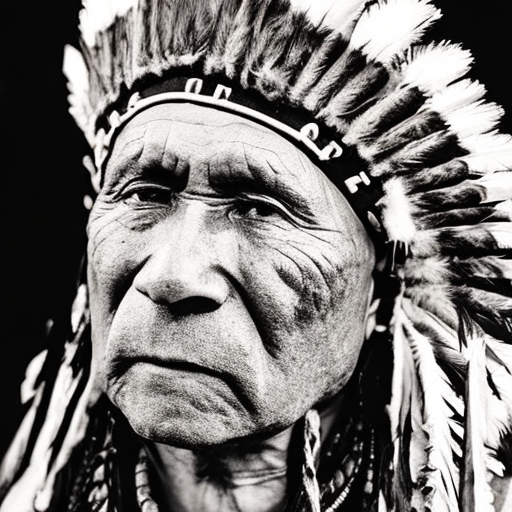

In [28]:
NUM_INFERENCE_STEPS = 20 # 7
GUIDANCE_SCALE = 7.5

generator = torch.Generator("cuda").manual_seed(0)
prompt = "portrait photo of a old warrior chief"
image = pipe(prompt, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator).images[0]

image

## Utils

In [37]:
def get_inputs(prompt, batch_size=1, num_inference_steps=20):
  generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
  prompts = [prompt for _ in range(batch_size)]

  return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_to_tensor(image):
    image_tensor = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5]) # normalize between -1 and 1
    ])(image)

    return image_tensor.unsqueeze(0).to("cuda", dtype=torch.float16) # unsqueeze(0) adds new dimension to tensor at index 0

  0%|          | 0/20 [00:00<?, ?it/s]

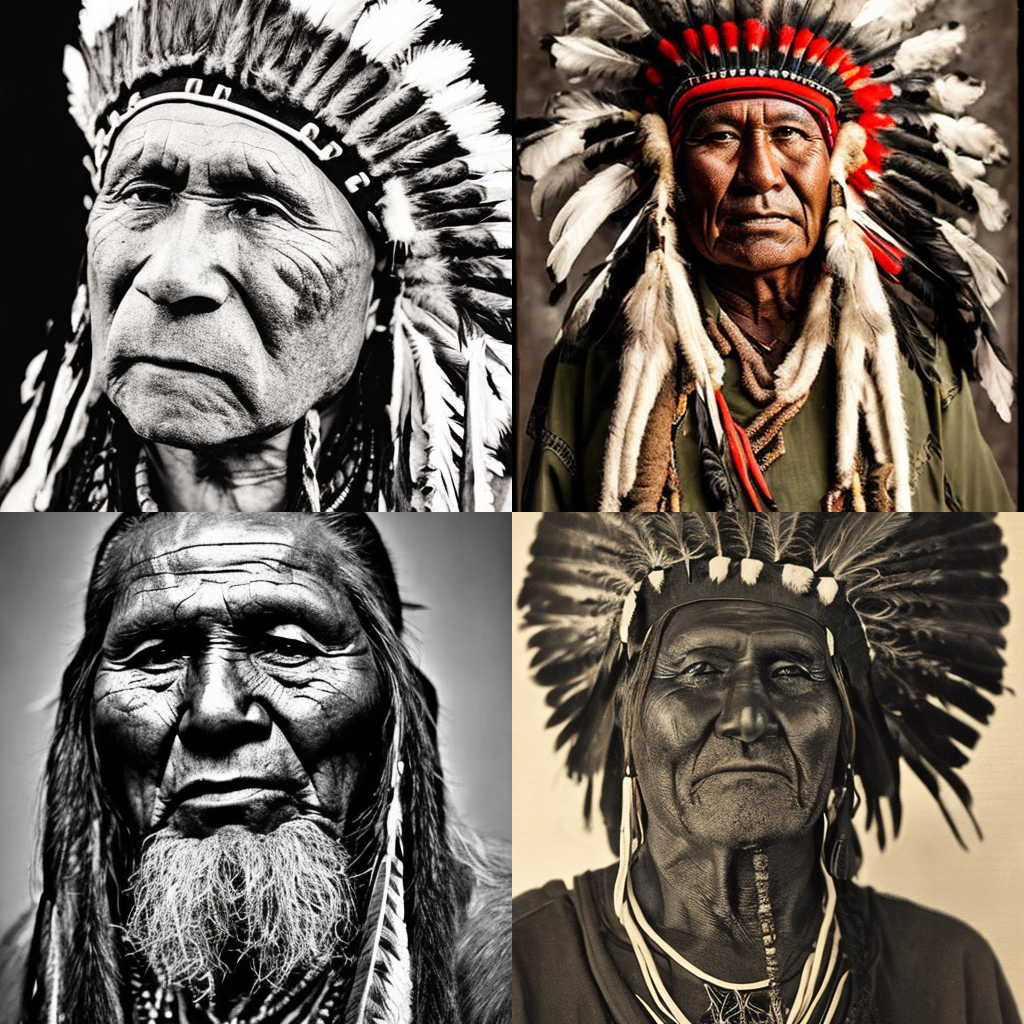

In [ ]:
images = pipe(**get_inputs(prompt=prompt, batch_size=4)).images
image_grid(images)

In [44]:
# VAE

def encode_image_vae(vae, image):
    image_tensor = image_to_tensor(image)
    with torch.no_grad():
        image_latent = vae.encode(image_tensor).latent_dist.sample() # samples from latent distribution

    return image_latent

def decode_vae(vae, image_latent):
    with torch.no_grad():
        image = vae.decode(image_latent).sample

    image = image.clamp(0, 1)

    return image

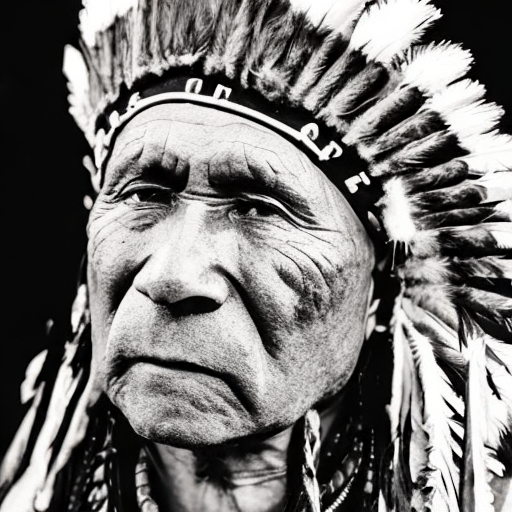

In [45]:
img_latent = encode_image_vae(pipe.vae, image)
img = decode_vae(pipe.vae, img_latent)
img_pil = transforms.ToPILImage()(img.squeeze())
img_pil

In [ ]:
# CLIP



TODO:

- generate images [x]
- access vae []
- access initial distribution []
- access clip encoder []